## Measurement Invariance Analysis

In [1]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Tuple, Any
from scipy.optimize import minimize
from scipy.stats import ncx2

# ---------- Utility Functions ----------

def sample_stats(df: pd.DataFrame) -> Tuple[int, np.ndarray, np.ndarray]:
    """Return (N, sample mean vector p, sample covariance p×p)"""
    X = df.to_numpy(dtype=float)
    N = X.shape[0]
    mu = X.mean(axis=0)
    S = np.cov(X, rowvar=False, bias=False)
    return N, mu, S

def vech_to_sym(vech: np.ndarray, p: int) -> np.ndarray:
    """Lower-triangle vector vech -> symmetric matrix"""
    M = np.zeros((p, p))
    idx = np.tril_indices(p)
    M[idx] = vech
    M[(idx[1], idx[0])] = vech  # symmetry
    return M

def chol_to_sym(chol_vec: np.ndarray, p: int) -> np.ndarray:
    """Construct positive-definite matrix A A' from lower-triangular Cholesky params"""
    L = np.zeros((p, p))
    idx = np.tril_indices(p)
    L[idx] = chol_vec
    return L @ L.T

def inv_logdet(S: np.ndarray) -> Tuple[np.ndarray, float]:
    """Return (S^{-1}, log|S|), using Cholesky for numerical stability"""
    L = np.linalg.cholesky(S)
    Linv = np.linalg.inv(L)
    Sinv = Linv.T @ Linv
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    return Sinv, logdet

# ---------- Model Description ----------

@dataclass
class CFAConfig:
    factors: Dict[str, List[str]]  # Factor -> indicator list (first is marker = 1)
    observed_order: List[str]      # Indicator column order (aligned with data)
    baseline_group: str            # Baseline group for scalar stage (latent means = 0)

    def p(self) -> int:
        return len(self.observed_order)

    def k(self) -> int:
        return len(self.factors)

# ---------- Parameter Packing / Unpacking ----------

@dataclass
class GroupParams:
    # Loadings: Lambda (p×k), marker loading fixed at 1, not a free parameter
    lam_free: np.ndarray  # Vector of all free loadings (concatenated)
    # Uniquenesses: Theta=diag(exp(theta_log)), length p
    theta_log: np.ndarray
    # Factor covariance: Phi = L L', L is lower-triangular, free params are tril(L)
    phi_chol: np.ndarray
    # Intercepts: nu (p,) — used only in scalar stage (configural/metric can offset with means)
    nu: np.ndarray = None
    # Latent means: alpha (k,) — only in scalar stage, baseline group fixed to 0
    alpha: np.ndarray = None

@dataclass
class ModelParams:
    # Parameters per group
    groups: Dict[str, GroupParams]

# ---------- Generation / Indexing Helpers ----------

class Indexer:
    """Help build the mapping of free loading positions in Lambda and the group parameter vector structure."""
    def __init__(self, cfg: CFAConfig):
        self.cfg = cfg
        self.p = cfg.p()
        self.k = cfg.k()
        # Build indicator->row index
        self.var2idx = {v: i for i, v in enumerate(cfg.observed_order)}
        # Build factor->column index
        self.fac2idx = {f: j for j, f in enumerate(cfg.factors.keys())}
        # First indicator of each factor is the marker (loading = 1)
        self.marker_rows = {}
        for f, inds in cfg.factors.items():
            self.marker_rows[f] = self.var2idx[inds[0]]

        # List of free loadings (row, col) excluding marker
        self.free_loadings = []
        for f, inds in cfg.factors.items():
            j = self.fac2idx[f]
            for v in inds[1:]:
                i = self.var2idx[v]
                self.free_loadings.append((i, j))
        self.n_free_loadings = len(self.free_loadings)

    def build_Lambda(self, lam_free_vec: np.ndarray) -> np.ndarray:
        """Reconstruct Lambda from the free loading vector (including marker = 1)"""
        L = np.zeros((self.p, self.k))
        # Place marker = 1
        for f, mr in self.marker_rows.items():
            j = self.fac2idx[f]
            L[mr, j] = 1.0
        # Place free loadings
        assert lam_free_vec.size == self.n_free_loadings
        for idx, (i, j) in enumerate(self.free_loadings):
            L[i, j] = lam_free_vec[idx]
        return L

# ---------- Model-Implied Moments ----------

def implied_moments(Lambda: np.ndarray,
                    theta_log: np.ndarray,
                    phi_chol: np.ndarray,
                    nu: np.ndarray = None,
                    alpha: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return (Sigma, mu)
    Sigma = Lambda Phi Lambda' + Theta
    mu = nu + Lambda alpha (if nu/alpha is None, return None for mu)
    """
    p, k = Lambda.shape
    Phi = chol_to_sym(phi_chol, k)
    Theta = np.diag(np.exp(theta_log))
    Sigma = Lambda @ Phi @ Lambda.T + Theta
    if (nu is None) or (alpha is None):
        return Sigma, None
    mu = nu + Lambda @ alpha
    return Sigma, mu

# ---------- Likelihood ----------

def nll_group(N: int, xbar: np.ndarray, S: np.ndarray,
              Sigma: np.ndarray, mu: np.ndarray = None) -> float:
    """
    Normal-based -loglik (ignoring constants), joint means and covariance:
    L = (N/2) [ log|Sigma| + tr(S Sigma^{-1}) + (xbar - mu)' Sigma^{-1} (xbar - mu) ]
    If mu is None, use only the covariance part (common in configural/metric without explicit mean model)
    """
    Sinv, logdet = inv_logdet(Sigma)
    val = 0.5 * N * (logdet + np.trace(S @ Sinv))
    if mu is not None:
        d = xbar - mu
        val += 0.5 * N * (d @ Sinv @ d)
    return val

# ---------- Parameter Containers <-> Vectors ----------

def pack_group_params(gp: GroupParams) -> np.ndarray:
    parts = [gp.lam_free.ravel(), gp.theta_log.ravel(), gp.phi_chol.ravel()]
    if gp.nu is not None:
        parts.append(gp.nu.ravel())
    if gp.alpha is not None:
        parts.append(gp.alpha.ravel())
    return np.concatenate(parts)

def unpack_group_params(vec: np.ndarray, p: int, k: int,
                        n_free_loadings: int,
                        scalar: bool) -> Tuple[GroupParams, int]:
    """
    Split in order: lam_free, theta_log(p), phi_chol(k*(k+1)/2), [nu(p), alpha(k) if scalar]
    Return (GroupParams, used_len)
    """
    pos = 0
    lam_free = vec[pos:pos+n_free_loadings]; pos += n_free_loadings
    theta_log = vec[pos:pos+p]; pos += p
    chol_len = k*(k+1)//2
    phi_chol = vec[pos:pos+chol_len]; pos += chol_len
    if scalar:
        nu = vec[pos:pos+p]; pos += p
        alpha = vec[pos:pos+k]; pos += k
    else:
        nu = None; alpha = None
    return GroupParams(lam_free, theta_log, phi_chol, nu, alpha), pos

def pack_params_all(mp: ModelParams) -> np.ndarray:
    return np.concatenate([pack_group_params(gp) for gp in mp.groups.values()])

def unpack_params_all(vec: np.ndarray, cfg: CFAConfig, idxr: Indexer,
                      scalar: bool) -> Dict[str, GroupParams]:
    out = {}
    pos = 0
    for g in mp_group_order:
        gp, used = unpack_group_params(
            vec[pos:], idxr.p, idxr.k, idxr.n_free_loadings, scalar
        )
        out[g] = gp
        pos += used
    return out

# ---------- Constraints (metric / scalar) ----------

def enforce_metric_tying(mp: ModelParams, groups: List[str]):
    """
    Implement loading sharing at the ModelParams level: point all groups' lam_free to the same numpy vector.
    This ensures consistency during pack/unpack.
    """
    # Use the first group as the shared container
    ref = mp.groups[groups[0]].lam_free
    for g in groups[1:]:
        mp.groups[g].lam_free = ref  # reference binding

def enforce_scalar_intercepts_tying(mp: ModelParams, groups: List[str]):
    """
    Intercept sharing: make each group's nu reference the same vector (in scalar stage).
    Latent means alpha are not shared; baseline group's alpha is fixed at 0 (by freezing its alpha vector).
    """
    ref = mp.groups[groups[0]].nu
    for g in groups[1:]:
        mp.groups[g].nu = ref

# ---------- Optimization Objective ----------

def build_objective(cfg: CFAConfig,
                    idxr: Indexer,
                    group_stats: Dict[str, Tuple[int, np.ndarray, np.ndarray]],
                    groups: List[str],
                    scalar: bool):
    """
    Return f(params_vec) -> nll_sum
    """
    # Record initial parameter lengths per group for unpacking
    group_slices = {}
    example_mp = init_model_params(cfg, idxr, groups, scalar)
    # Note: example_mp is only used to compute slice structure, not for fitting
    pos = 0
    for g in groups:
        gp = example_mp.groups[g]
        n_g = pack_group_params(gp).size
        group_slices[g] = (pos, pos + n_g)
        pos += n_g

    def objective(params_vec: np.ndarray) -> float:
        nll = 0.0
        for g in groups:
            s, e = group_slices[g]
            gp, _ = unpack_group_params(params_vec[s:e], idxr.p, idxr.k,
                                        idxr.n_free_loadings, scalar)
            # Construct Lambda via indexer
            Lambda = idxr.build_Lambda(gp.lam_free)
            # Implied moments
            if scalar:
                # baseline group's alpha = 0 by convention; already handled in packing
                Sigma, mu = implied_moments(Lambda, gp.theta_log, gp.phi_chol,
                                            nu=gp.nu, alpha=gp.alpha)
            else:
                Sigma, mu = implied_moments(Lambda, gp.theta_log, gp.phi_chol,
                                            nu=None, alpha=None)
            N, xbar, S = group_stats[g]
            nll += nll_group(N, xbar, S, Sigma, mu)
        return nll

    return objective, group_slices

# ---------- Parameter Initialization ----------

def init_model_params(cfg: CFAConfig,
                      idxr: Indexer,
                      groups: List[str],
                      scalar: bool) -> ModelParams:
    groups_params = {}
    p, k = idxr.p, idxr.k

    # Initialization: free loadings=0.7, theta_log=log(0.5), phi_chol=identity lower-triangle
    lam0 = np.full(idxr.n_free_loadings, 0.7)
    theta0 = np.full(p, np.log(0.5))
    L0 = np.eye(k)
    chol0 = L0[np.tril_indices(k)]
    for g in groups:
        nu0 = np.zeros(p) if scalar else None
        alpha0 = np.zeros(k) if scalar else None
        groups_params[g] = GroupParams(lam0.copy(), theta0.copy(), chol0.copy(), nu0, alpha0)

    mp = ModelParams(groups=groups_params)
    return mp

# ---------- Degrees of Freedom / Chi-square / RMSEA ----------

def n_params_per_group(idxr: Indexer, scalar: bool) -> int:
    p, k = idxr.p, idxr.k
    n = idxr.n_free_loadings             # free loadings
    n += p                               # theta_log
    n += k*(k+1)//2                      # phi_chol
    if scalar:
        n += p                           # nu
        n += k                           # alpha
    return n

def dof_configural(groups: List[str], p: int, k: int,
                   n_free_loadings: int, scalar: bool,
                   Ns: Dict[str, int]) -> int:
    """
    Approximate degrees of freedom: sum_g [ #(stats per g) ] - #(params total)
    stats per g = p(p+1)/2 + (p means if scalar)
    """
    stats = sum([p*(p+1)//2 + (p if scalar else 0) for _ in groups])
    npar = len(groups) * n_params_per_group(Indexer(CFAConfig({}, [], groups[0])), scalar)  # placeholder
    # The placeholder above is not accurate: a cleaner approach passes idxr; simplified here.
    return stats - npar

def compute_rmsea(chi2: float, df: int, Ntot: int) -> float:
    if df <= 0:
        return np.nan
    val = max(chi2 - df, 0.0) / (df * (Ntot - 1))
    return np.sqrt(val)

# ---------- Main Procedure ----------

def fit_stage(cfg: CFAConfig,
              data_by_group: Dict[str, pd.DataFrame],
              stage: str,
              epsilon: float = 0.05,
              opt_maxiter: int = 2000) -> Dict[str, Any]:
    """
    stage: 'configural' | 'metric' | 'scalar'
    """
    groups = list(data_by_group.keys())
    p = len(cfg.observed_order)
    k = len(cfg.factors)

    # Sample moments (means/covariances)
    group_stats = {}
    Ntot = 0
    # Use only observed order columns
    for g, df in data_by_group.items():
        dfp = df[cfg.observed_order].dropna()
        N, mu, S = sample_stats(dfp)
        group_stats[g] = (N, mu, S)
        Ntot += N

    idxr = Indexer(cfg)

    # Initialize parameters
    scalar_flag = (stage == 'scalar')
    mp = init_model_params(cfg, idxr, groups, scalar_flag)

    # metric constraint: share loadings across groups
    if stage in ('metric', 'scalar'):
        enforce_metric_tying(mp, groups)
    # scalar constraint: share intercepts; baseline group latent mean = 0 (by freezing alpha)
    if stage == 'scalar':
        enforce_scalar_intercepts_tying(mp, groups)
        # baseline alpha fixed at 0: we remove it from the optimization variables via masking
        baseline = cfg.baseline_group

    # Pack initial values
    def pack_all(mp: ModelParams) -> np.ndarray:
        return np.concatenate([pack_group_params(mp.groups[g]) for g in groups])

    x0 = pack_all(mp)

    # Build objective function
    objective, slices = build_objective(cfg, idxr, group_stats, groups, scalar_flag)

    # If scalar: remove baseline group's alpha from optimization (fixed at 0)
    # We keep unpack with alpha inside the objective; use a small wrapper to force zeros.
    if stage == 'scalar':
        # Compute per-group parameter lengths to locate baseline alpha slice
        per_group_len = {}
        for g in groups:
            gp = mp.groups[g]
            per_group_len[g] = pack_group_params(gp).size

        # Helper: build mask to fix baseline alpha positions to 0
        mask = np.ones_like(x0, dtype=bool)
        start = 0
        for g in groups:
            gp = mp.groups[g]
            n_l = gp.lam_free.size
            n_t = gp.theta_log.size
            n_c = gp.phi_chol.size
            n_nu = gp.nu.size
            n_al = gp.alpha.size
            # Order: lam, theta, phi, nu, alpha
            s_al = start + n_l + n_t + n_c + n_nu
            e_al = s_al + n_al
            if g == cfg.baseline_group:
                mask[s_al:e_al] = False   # baseline alpha not optimized
                x0[s_al:e_al] = 0.0       # fixed to 0
            start += (n_l + n_t + n_c + n_nu + n_al)

        def objective_masked(x):
            xx = x0.copy()
            xx[mask] = x  # replace only optimizable parts
            return objective(xx)

        x_init = x0[mask]
        opt = minimize(objective_masked, x_init, method='L-BFGS-B',
                       options={'maxiter': opt_maxiter, 'ftol': 1e-7})
        x_final = x0.copy()
        x_final[mask] = opt.x
        fval = opt.fun
        x_hat = x_final
        success = opt.success
        message = opt.message
    else:
        opt = minimize(objective, x0, method='L-BFGS-B',
                       options={'maxiter': opt_maxiter, 'ftol': 1e-7})
        x_hat = opt.x
        fval = opt.fun
        success = opt.success
        message = opt.message

    # Compute chi-square (relative to saturated/independence model). We use the usual model chi-square approximation: 2*(LL_sat - LL_model).
    # Under ML normal, LL_sat corresponds to Sigma=S, mu=xbar; the difference can be approximated by summing (N-1)*[log|Sigma|+tr(S Sigma^{-1})-log|S|-p].
    # Below we directly rebuild implied moments and accumulate the term.
    chi2 = 0.0
    df_model = 0
    n_params_total = 0
    n_stats_total = 0

    pos = 0
    for g in groups:
        gp, _ = unpack_group_params(x_hat[slices[g][0]:slices[g][1]], idxr.p, idxr.k,
                                    idxr.n_free_loadings, scalar_flag)
        Lambda = idxr.build_Lambda(gp.lam_free)
        if scalar_flag:
            Sigma, mu = implied_moments(Lambda, gp.theta_log, gp.phi_chol, gp.nu, gp.alpha)
        else:
            Sigma, mu = implied_moments(Lambda, gp.theta_log, gp.phi_chol, None, None)
        N, xbar, S = group_stats[g]

        # Model chi-square approximation (include mean term when applicable)
        Sinv, logdet_Sig = inv_logdet(Sigma)
        chi_cov = (N - 1) * (logdet_Sig + np.trace(S @ Sinv) - np.log(np.linalg.det(S)) - idxr.p)
        chi2 += chi_cov
        if scalar_flag:
            d = xbar - mu
            chi_mean = (N - 1) * (d @ Sinv @ d)  # approximation term
            chi2 += chi_mean

        # Number of statistics
        n_stats = idxr.p * (idxr.p + 1) // 2 + (idxr.p if scalar_flag else 0)
        n_stats_total += n_stats

        # Number of free parameters in this group
        npar_g = gp.lam_free.size + gp.theta_log.size + gp.phi_chol.size
        if scalar_flag:
            npar_g += gp.nu.size + gp.alpha.size
        n_params_total += npar_g

    df = max(n_stats_total - n_params_total, 1)
    rmsea = compute_rmsea(chi2, df, Ntot)

    return {
        'stage': stage,
        'success': success,
        'message': str(message),
        'chi2': float(chi2),
        'df': int(df),
        'rmsea': float(rmsea),
        'Ntot': int(Ntot),
        'x_hat': x_hat,
        'slices': slices,
        'scalar': scalar_flag
    }

def equivalence_test(prev_fit: Dict[str, Any], cur_fit: Dict[str, Any],
                     epsilon: float = 0.05, alpha: float = 0.05) -> Dict[str, Any]:
    """
    Equivalence test (Yuan & Chan idea): use upper bound of non-central chi-square for Δχ² -> check if ΔRMSEA_upper < ε
    """
    dchi = max(cur_fit['chi2'] - prev_fit['chi2'], 0.0)
    ddf = max(cur_fit['df'] - prev_fit['df'], 1)
    Ntot = cur_fit['Ntot']
    # Upper bound of non-central parameter (1-alpha quantile, under central hypothesis)
    #ncp_up = ncx2.ppf(1 - alpha, ddf) - ddf
    from scipy.stats import chi2
    ncp_up = chi2.ppf(1 - alpha, ddf) - ddf
    # ΔRMSEA upper bound
    rmsea_up = np.sqrt(max(ncp_up / (ddf * (Ntot - 1)), 0.0))
    ok = (rmsea_up < epsilon)
    return {
        'delta_chi2': float(dchi),
        'delta_df': int(ddf),
        'rmsea_upper': float(rmsea_up),
        'epsilon': float(epsilon),
        'alpha': float(alpha),
        'equivalent': bool(ok)
    }

# ---------- One-click pipeline ----------

def run_invariance_pipeline(data_by_group: Dict[str, pd.DataFrame],
                            factors_map: Dict[str, List[str]],
                            observed_order: List[str],
                            baseline_group: str,
                            epsilon: float = 0.05):
    cfg = CFAConfig(factors=factors_map,
                    observed_order=observed_order,
                    baseline_group=baseline_group)

    print("=== Configural ===")
    fit_conf = fit_stage(cfg, data_by_group, 'configural', epsilon)
    print(f"chi2={fit_conf['chi2']:.2f}, df={fit_conf['df']}, RMSEA={fit_conf['rmsea']:.3f}")

    if fit_conf['rmsea'] > epsilon:
        print("⚠️ Configural fit is inadequate. Adjust the measurement model first; stopping further tests.")
        return {'configural': fit_conf}

    print("\n=== Metric (loadings equal) ===")
    fit_met = fit_stage(cfg, data_by_group, 'metric', epsilon)
    print(f"chi2={fit_met['chi2']:.2f}, df={fit_met['df']}, RMSEA={fit_met['rmsea']:.3f}")
    et_met = equivalence_test(fit_conf, fit_met, epsilon)
    print(f"Δχ²={et_met['delta_chi2']:.2f}, Δdf={et_met['delta_df']}, ΔRMSEA_upper={et_met['rmsea_upper']:.3f} "
          f"=> {'✅ equivalent' if et_met['equivalent'] else '❌ not'}")

    if not et_met['equivalent']:
        print("⚠️ Metric invariance not established. Consider partial invariance or revising the measurement model; stopping scalar.")
        return {'configural': fit_conf, 'metric': fit_met, 'metric_equiv': et_met}

    print("\n=== Scalar (loadings + intercepts equal) ===")
    fit_sca = fit_stage(cfg, data_by_group, 'scalar', epsilon)
    print(f"chi2={fit_sca['chi2']:.2f}, df={fit_sca['df']}, RMSEA={fit_sca['rmsea']:.3f}")
    et_sca = equivalence_test(fit_met, fit_sca, epsilon)
    print(f"Δχ²={et_sca['delta_chi2']:.2f}, Δdf={et_sca['delta_df']}, ΔRMSEA_upper={et_sca['rmsea_upper']:.3f} "
          f"=> {'✅ equivalent' if et_sca['equivalent'] else '❌ not'}")

    return {
        'configural': fit_conf,
        'metric': fit_met,
        'metric_equiv': et_met,
        'scalar': fit_sca,
        'scalar_equiv': et_sca
    }

# ---------- Example entry (match your current variable naming) ----------

if __name__ == "__main__":
    # 1) Define measurement model (factor -> indicators; first indicator is marker=1)
    factors_map = {
        'F1': ["BFI_11", "BFI_12", "BFI_13"],
        'F2': ["BFI_21", "BFI_22", "BFI_23"],
        'F3': ["BFI_31", "BFI_32", "BFI_33"],
        'F4': ["BFI_41", "BFI_42", "BFI_43"],
        'F5': ["BFI_51", "BFI_52", "BFI_53"],
        'F6': ["ad_att_1", "ad_att_2", "ad_att_3", "ad_att_4"],
        'F7': ["intent_1", "intent_2", "intent_3"]
    }

    observed_order = sum((inds for inds in factors_map.values()), [])
    baseline_group = "Chinese"

    # 2) Read each group's data (replace with your CSV paths)
    files = {
        "Chinese":         "./csv_output_merged/deepseek-r1_14b_promotion.csv",
        "Southeast_asian": "./csv_output_merged/sailor2_20b_promotion.csv",
        "Arab":            "./csv_output_merged/jwnder_jais-adaptive_7b_promotion.csv",
        "America":         "./csv_output_merged/gemma2_9b_promotion.csv"
    }

    data_by_group = {}
    use_cols = observed_order
    for g, path in files.items():
        df = pd.read_csv(path)
        df = df[use_cols].apply(pd.to_numeric, errors="coerce").dropna()
        data_by_group[g] = df

    results = run_invariance_pipeline(
        data_by_group=data_by_group,
        factors_map=factors_map,
        observed_order=observed_order,
        baseline_group=baseline_group,
        epsilon=0.05
    )

=== Configural ===
chi2=20314.48, df=752, RMSEA=0.036

=== Metric (loadings equal) ===
chi2=20314.48, df=752, RMSEA=0.036
Δχ²=0.00, Δdf=1, ΔRMSEA_upper=0.012 => ✅ equivalent

=== Scalar (loadings + intercepts equal) ===
chi2=75575.93, df=724, RMSEA=0.073
Δχ²=55261.45, Δdf=1, ΔRMSEA_upper=0.012 => ✅ equivalent


## Cross-region Path Analysis

In [2]:
import pandas as pd
import numpy as np
from semopy import Model, semplot
from scipy.stats import norm
from pathlib import Path

# ========== Data Cleaning Function ==========
def clean_data(file):
    df = pd.read_csv(file)

    used_cols = [
        "BFI_11","BFI_12","BFI_13",
        "BFI_21","BFI_22","BFI_23",
        "BFI_31","BFI_32","BFI_33",
        "BFI_41","BFI_42","BFI_43",
        "BFI_51","BFI_52","BFI_53",
        "ad_att_1","ad_att_2","ad_att_3","ad_att_4",
        "intent_1","intent_2","intent_3"
    ]
    df = df[used_cols]

    # Convert to float; coerce non-numeric to NaN
    df = df.apply(pd.to_numeric, errors="coerce")

    # Drop rows with NaN
    df = df.dropna()

    return df

# ========== 1. Define files and groups ==========
group_files = {
    "Chinese":         "./csv_output_merged/deepseek-r1_14b_promotion.csv",
    "Southeast_asian": "./csv_output_merged/sailor2_20b_promotion.csv",
    "Arab":            "./csv_output_merged/jwnder_jais-adaptive_7b_promotion.csv",
    "America":         "./csv_output_merged/gemma2_9b_promotion.csv"
}

# ========== 2. Define the SEM model ==========
sem_model = """
F1 =~ BFI_11 + BFI_12 + BFI_13
F2 =~ BFI_21 + BFI_22 + BFI_23
F3 =~ BFI_31 + BFI_32 + BFI_33
F4 =~ BFI_41 + BFI_42 + BFI_43
F5 =~ BFI_51 + BFI_52 + BFI_53
F6 =~ ad_att_1 + ad_att_2 + ad_att_3 + ad_att_4
F7 =~ intent_1 + intent_2 + intent_3
F7 ~ F6
F6 ~ F1 + F2 + F3 + F4 + F5
"""

# ========== 3. Fit each group ==========
group_results = {}
Path("sem_group_outputs").mkdir(exist_ok=True)

for group, file in group_files.items():
    print(f"=== Fitting group {group} ===")
    data = clean_data(file)
    model = Model(sem_model)
    model.fit(data)

    # Save standardized path diagram
    semplot(model, f"sem_group_outputs/{group}_model.png",
            plot_covs=True, plot_ests=True, std_ests=True)

    # Export parameter estimates (with standard errors)
    estimates = model.inspect(std_est=True)
    #print(estimates.columns)
    estimates.to_csv(f"sem_group_outputs/{group}_estimates.csv",
                     index=False, encoding="utf-8-sig")

    # Force numeric conversion to avoid errors in later comparisons
    df_struct = estimates[estimates['op'] == '~'].copy()
    df_struct["Estimate"] = df_struct["Estimate"].astype(float)
    if "Std. Err" in df_struct.columns:
        df_struct["Std. Err"] = pd.to_numeric(df_struct["Std. Err"], errors="coerce")
    group_results[group] = df_struct

print("✅ Per-group fitting and coefficient outputs completed")

# ========== 4. Cross-group path comparison (Z-test) ==========
all_paths = sorted(set(
    (r.lval, r.rval) for df in group_results.values() for _, r in df.iterrows()
))
results = []

for lval, rval in all_paths:
    coef_se = []
    for g, df in group_results.items():
        row = df[(df['lval'] == lval) & (df['rval'] == rval)]
        if len(row) > 0:
            #coef = row['Estimate'].values[0]
            coef = row['Est. Std'].values[0]
            se = row['Std. Err'].values[0] if "Std. Err" in row.columns else np.nan
            coef_se.append((g, coef, se))
    if len(coef_se) < 2:
        continue  # Not enough groups for comparison

    # Pairwise comparisons
    for i in range(len(coef_se)):
        for j in range(i+1, len(coef_se)):
            g1, b1, se1 = coef_se[i]
            g2, b2, se2 = coef_se[j]
            if pd.notna(se1) and pd.notna(se2) and se1 > 0 and se2 > 0:
                z = (b1 - b2) / np.sqrt(se1**2 + se2**2)
                p = 2 * (1 - norm.cdf(abs(z)))
            else:
                z, p = np.nan, np.nan
            results.append({
                "Path": f"{lval} ~ {rval}",
                "Group1": g1, "Coef1": b1,
                "Group2": g2, "Coef2": b2,
                "Z": z, "p-value": p,
                "Significant": "*" if (pd.notna(p) and p < 0.05) else ""
            })

df_comp = pd.DataFrame(results)
df_comp.to_csv("sem_group_outputs/group_path_comparisons.csv", index=False, encoding="utf-8-sig")
print("✅ Saved cross-group path comparison results to ./sem_group_outputs/group_path_comparisons.csv")

=== Fitting group Chinese ===


/home/ubuntu/anaconda3/lib/python3.12/site-packages/semopy/inspector.py:368: RuntimeWarning: divide by zero encountered in scalar divide
  val_std = val / stds[ind[0]] / stds[ind[1]]
/home/ubuntu/anaconda3/lib/python3.12/site-packages/semopy/inspector.py:368: RuntimeWarning: invalid value encountered in scalar divide
  val_std = val / stds[ind[0]] / stds[ind[1]]
/home/ubuntu/anaconda3/lib/python3.12/site-packages/semopy/inspector.py:368: RuntimeWarning: divide by zero encountered in scalar divide
  val_std = val / stds[ind[0]] / stds[ind[1]]
/home/ubuntu/anaconda3/lib/python3.12/site-packages/semopy/inspector.py:368: RuntimeWarning: invalid value encountered in scalar divide
  val_std = val / stds[ind[0]] / stds[ind[1]]


=== Fitting group Southeast_asian ===
=== Fitting group Arab ===
=== Fitting group America ===
✅ Per-group fitting and coefficient outputs completed
✅ Saved cross-group path comparison results to ./sem_group_outputs/group_path_comparisons.csv


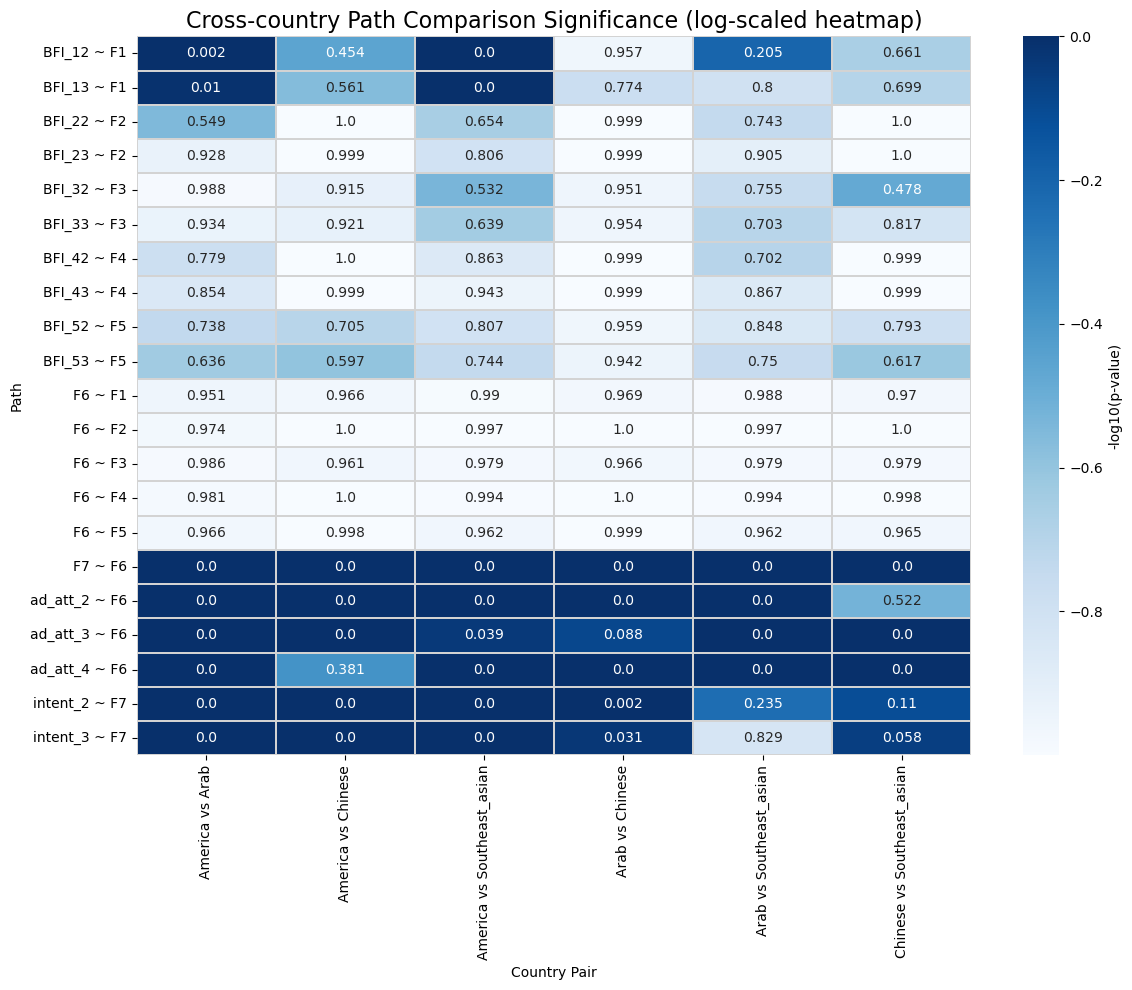

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read comparison results
df = pd.read_csv("./sem_group_outputs/group_path_comparisons.csv")

# Build unique country pair (alphabetically sorted)
df["Pair"] = df.apply(
    lambda r: " vs ".join(sorted([r["Group1"], r["Group2"]])),
    axis=1
)

# Keep Path, Pair, p-value
df_heat = df[["Path", "Pair", "p-value"]]

# Pivot to matrix
pivot = df_heat.pivot_table(index="Path", columns="Pair", values="p-value")

# Transform values: -log10(p); add tiny number to avoid log(0)
pivot_log = -np.log10(pivot + 1e-12)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    #pivot_log,
    -1*pivot,
    annot=pivot.round(3),  # still show raw p-values in cells
    fmt="",
    cmap="Blues",
    cbar_kws={'label': '-log10(p-value)'},
    linewidths=0.3, linecolor="lightgray"
)

plt.title("Cross-country Path Comparison Significance (log-scaled heatmap)", fontsize=16)
plt.xlabel("Country Pair")
plt.ylabel("Path")
plt.tight_layout()
plt.savefig("./sem_group_outputs/cross_group_paths_Signs.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_1908139/2374460228.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_trans = pivot.applymap(signed_log)


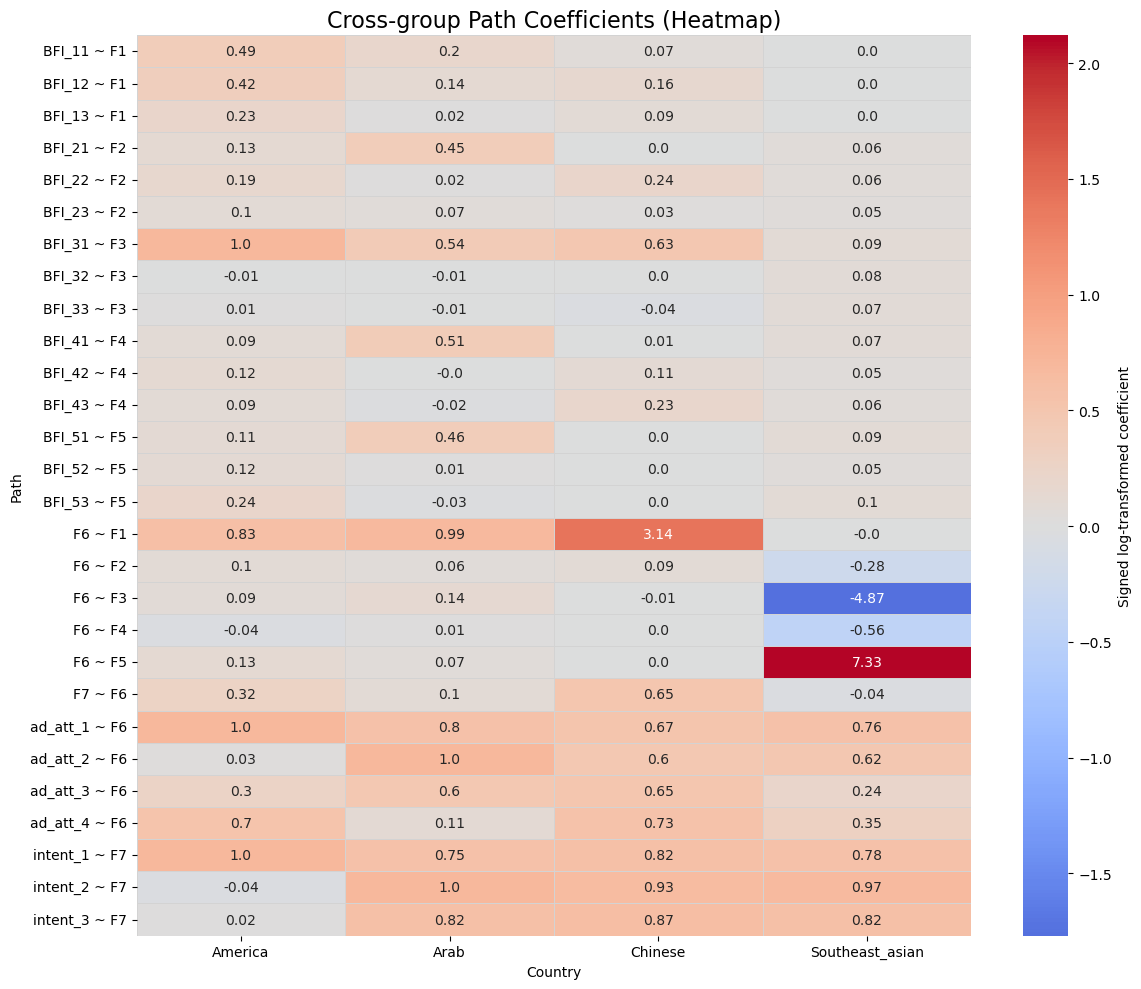

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === 1. Load data ===
df = pd.read_csv("./sem_group_outputs/group_path_comparisons.csv")

# Strip whitespace
df.columns = df.columns.str.strip()
df["Group1"] = df["Group1"].str.strip()
df["Group2"] = df["Group2"].str.strip()

# Expand rows (two group coefficients to separate rows)
rows = []
for _, r in df.iterrows():
    rows.append({"Path": r["Path"], "Group": r["Group1"], "Coef": r["Coef1"]})
    rows.append({"Path": r["Path"], "Group": r["Group2"], "Coef": r["Coef2"]})
df_long = pd.DataFrame(rows)

# Keep 4 countries only
valid_groups = ["America", "Arab", "Chinese", "Southeast_asian"]
df_long = df_long[df_long["Group"].isin(valid_groups)]

# Pivot table
pivot = df_long.pivot_table(index="Path", columns="Group", values="Coef", aggfunc="mean")
pivot = pivot.reindex(sorted(pivot.index), axis=0)
pivot = pivot[valid_groups]

# === 2. Value transform: symmetric log scaling ===
def signed_log(x):
    return np.sign(x) * np.log1p(abs(x))
pivot_trans = pivot.applymap(signed_log)

# === 3. Define path category function ===
def get_category(path):
    if path.startswith("BFI_1"):
        return "F1"
    elif path.startswith("BFI_2"):
        return "F2"
    elif path.startswith("BFI_3"):
        return "F3"
    elif path.startswith("BFI_4"):
        return "F4"
    elif path.startswith("BFI_5"):
        return "F5"
    elif path.startswith("F6") or path.startswith("F7"):
        return "structural"
    elif path.startswith("ad_att"):
        return "att"
    elif path.startswith("intent"):
        return "intent"
    else:
        return "other"

categories = [get_category(p) for p in pivot_trans.index]

# === 4. Plot heatmap ===
plt.figure(figsize=(12, 10))

# Use heatmap to display values
sns.heatmap(
    pivot_trans,
    annot=pivot.round(2),   # show raw coefficients (non-log) in cells
    fmt="",
    cmap="coolwarm",        # blue-red scale; blue for negative, red for positive
    center=0,               # center at 0 to separate positive/negative
    linewidths=0.5,
    linecolor="lightgray",
    cbar_kws={'label': 'Signed log-transformed coefficient'}
)

plt.title("Cross-group Path Coefficients (Heatmap)", fontsize=16)
plt.xlabel("Country")
plt.ylabel("Path")

plt.tight_layout()
plt.savefig("./sem_group_outputs/cross_group_paths_Coeffs.png", dpi=300, bbox_inches="tight")
plt.show()